In this notebook we will explore the wingbeat recordings. We will apply dimensionality techniques to visualize the data and perform unsupervised learning to cluster the recordings.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
#%matplotlib inline

import os
from scipy import signal

import seaborn as sn

___
### Reading Data

In [2]:
# reading the stored data
X = np.load('data/X.npy')
y = np.load('data/y.npy')

print(X.shape)

(5181, 5000)


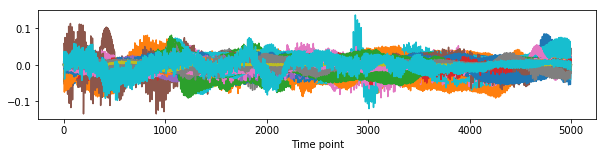

In [3]:
# look at first 100 patterns
plt.figure(figsize = (10,2))
plt.plot(X[:100,:].T)
plt.xlabel("Time point")
plt.draw()

In [4]:
target_names = target_names = ['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis', 'C. pipiens', 'C. quinquefasciatus']

___
### PCA Analysis

In [5]:
from sklearn import decomposition

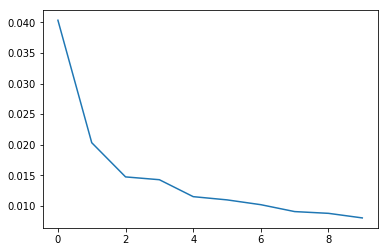

In [6]:
#%matplotlib inline
pca = decomposition.PCA(n_components=10)
pca.fit(X)
plt.plot(pca.explained_variance_)

<IPython.core.display.Javascript object>


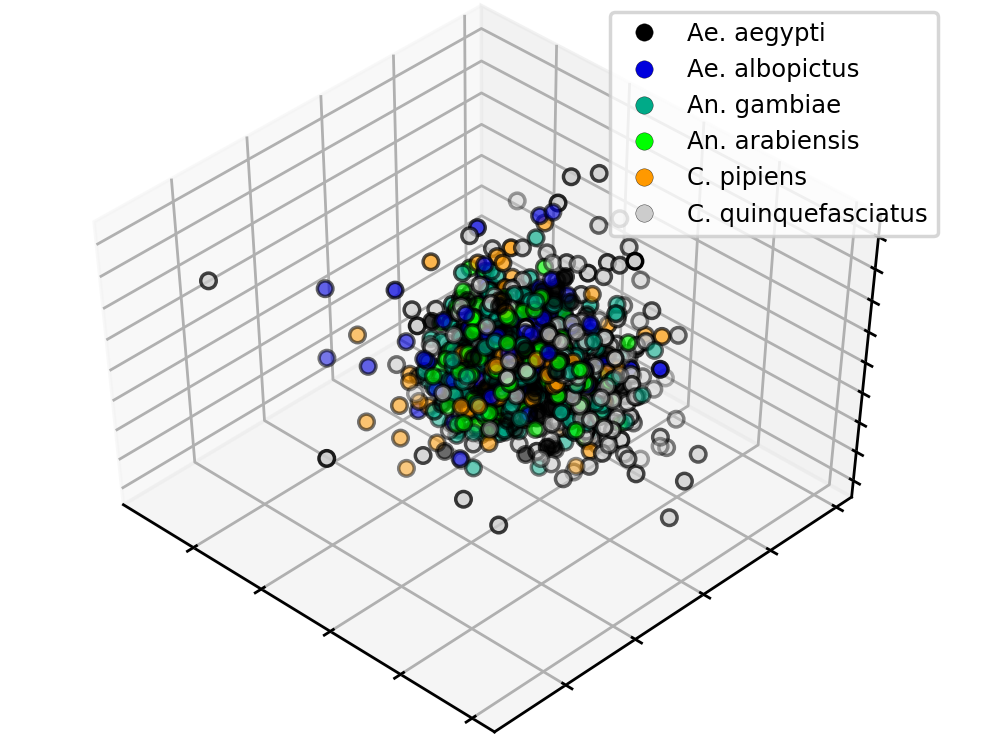

In [7]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
X_transformed = pca.transform(X)

sc = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], X_transformed[:, 2], c=y, cmap=plt.cm.spectral,
           edgecolor='k')


colors = [sc.cmap(sc.norm(i)) for i in np.unique(y)]
custom_lines = [plt.Line2D([],[], ls="", marker='o',mec='k', mfc=c, mew=.1, ms=5) for c in colors]
ax.legend(custom_lines, [lt for lt in target_names],loc='upper right', fontsize=7)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.show()

The decomposition of the raw data does not seem to reveal any obvious clusters. This is partially because the signals oscillate and PCA relies on data points exxibiting similar patterns across samples which is highly unlikely with raw sound (small shifts can lead to big changes in the data). Instead we will calculate the power spectrum of the signal using the Welch method.

In [35]:
fs = 8000
XX = np.zeros((X.shape[0],129)).astype("float32")   # allocate space
for i in range(X.shape[0]):
    XX[i] = 10*np.log10(signal.welch(X[i], fs=fs, window='hanning', nperseg=256, noverlap=128+64)[1])

In [36]:
XX.shape

(5181, 129)

In [37]:
# do PCA on the psd data
pca.fit(XX)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


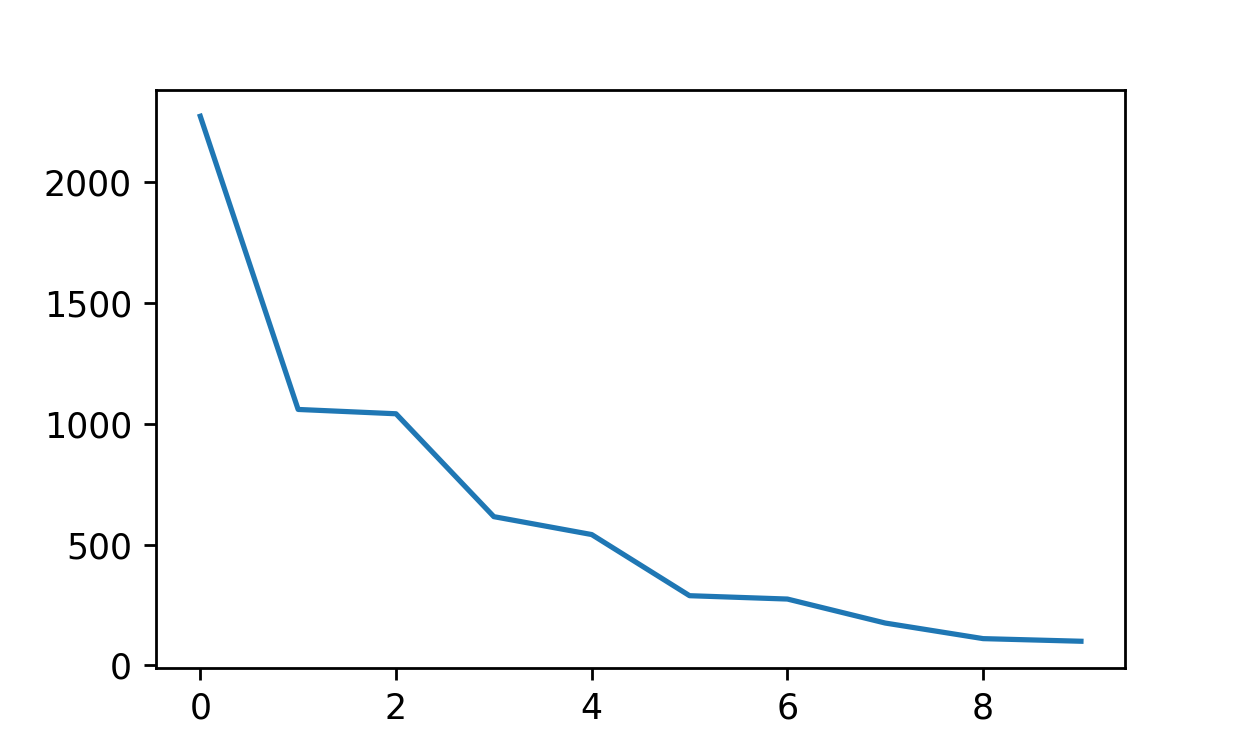

In [38]:
plt.figure(figsize = (5,3))
plt.plot(pca.explained_variance_)

In [12]:
XX_transformed = pca.transform(XX)

<IPython.core.display.Javascript object>


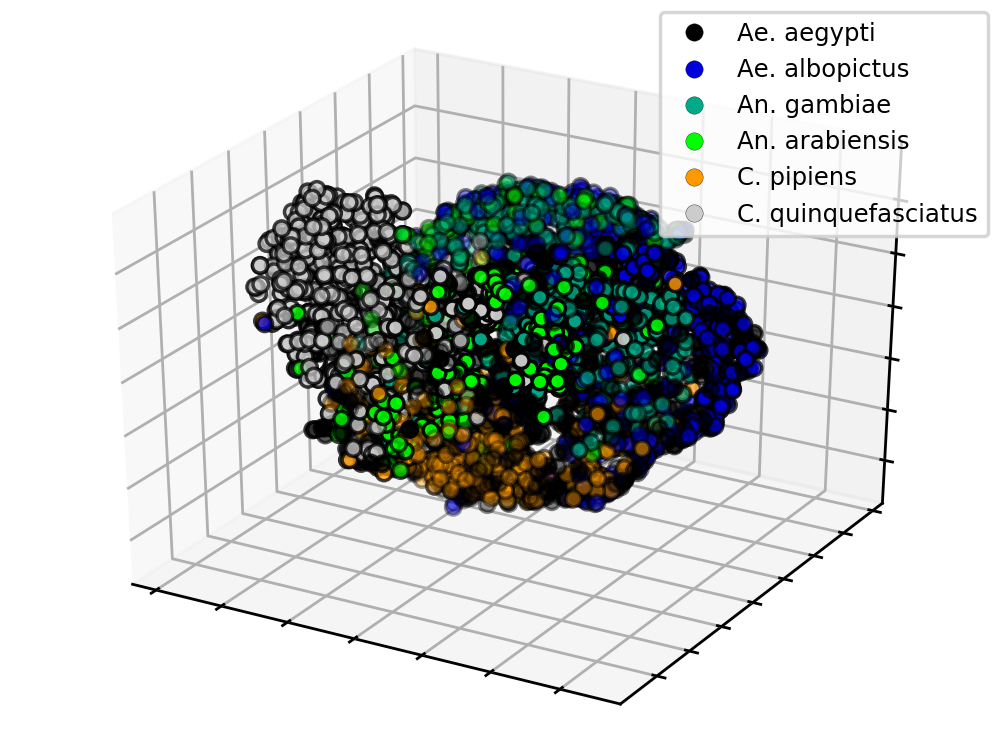

In [39]:
%matplotlib notebook
%matplotlib notebook
fig = plt.figure(figsize=(4, 3))
plt.clf()
#ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax = Axes3D(fig)
sc = ax.scatter(XX_transformed[:, 0], XX_transformed[:, 1], XX_transformed[:, 2], c=y, cmap=plt.cm.spectral,
           edgecolor='k')

colors = [sc.cmap(sc.norm(i)) for i in np.unique(y)]
custom_lines = [plt.Line2D([],[], ls="", marker='o',mec='k', mfc=c, mew=.1, ms=5) for c in colors]
ax.legend(custom_lines, [lt for lt in target_names],loc='upper right', fontsize=7)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.draw()

We clearly see individual classes of occupy the same volume in this 3-dimensional projection of the power spectra of the signals. A typical next step in the analysis will be to apply a clustering, however, in this case the boundary of the classes will be hard to disentangle without any supervision. In the next section we will discuss how to use the label information. 

Visualizing factors:

In [40]:
pca.components_.shape

(10, 129)

<IPython.core.display.Javascript object>


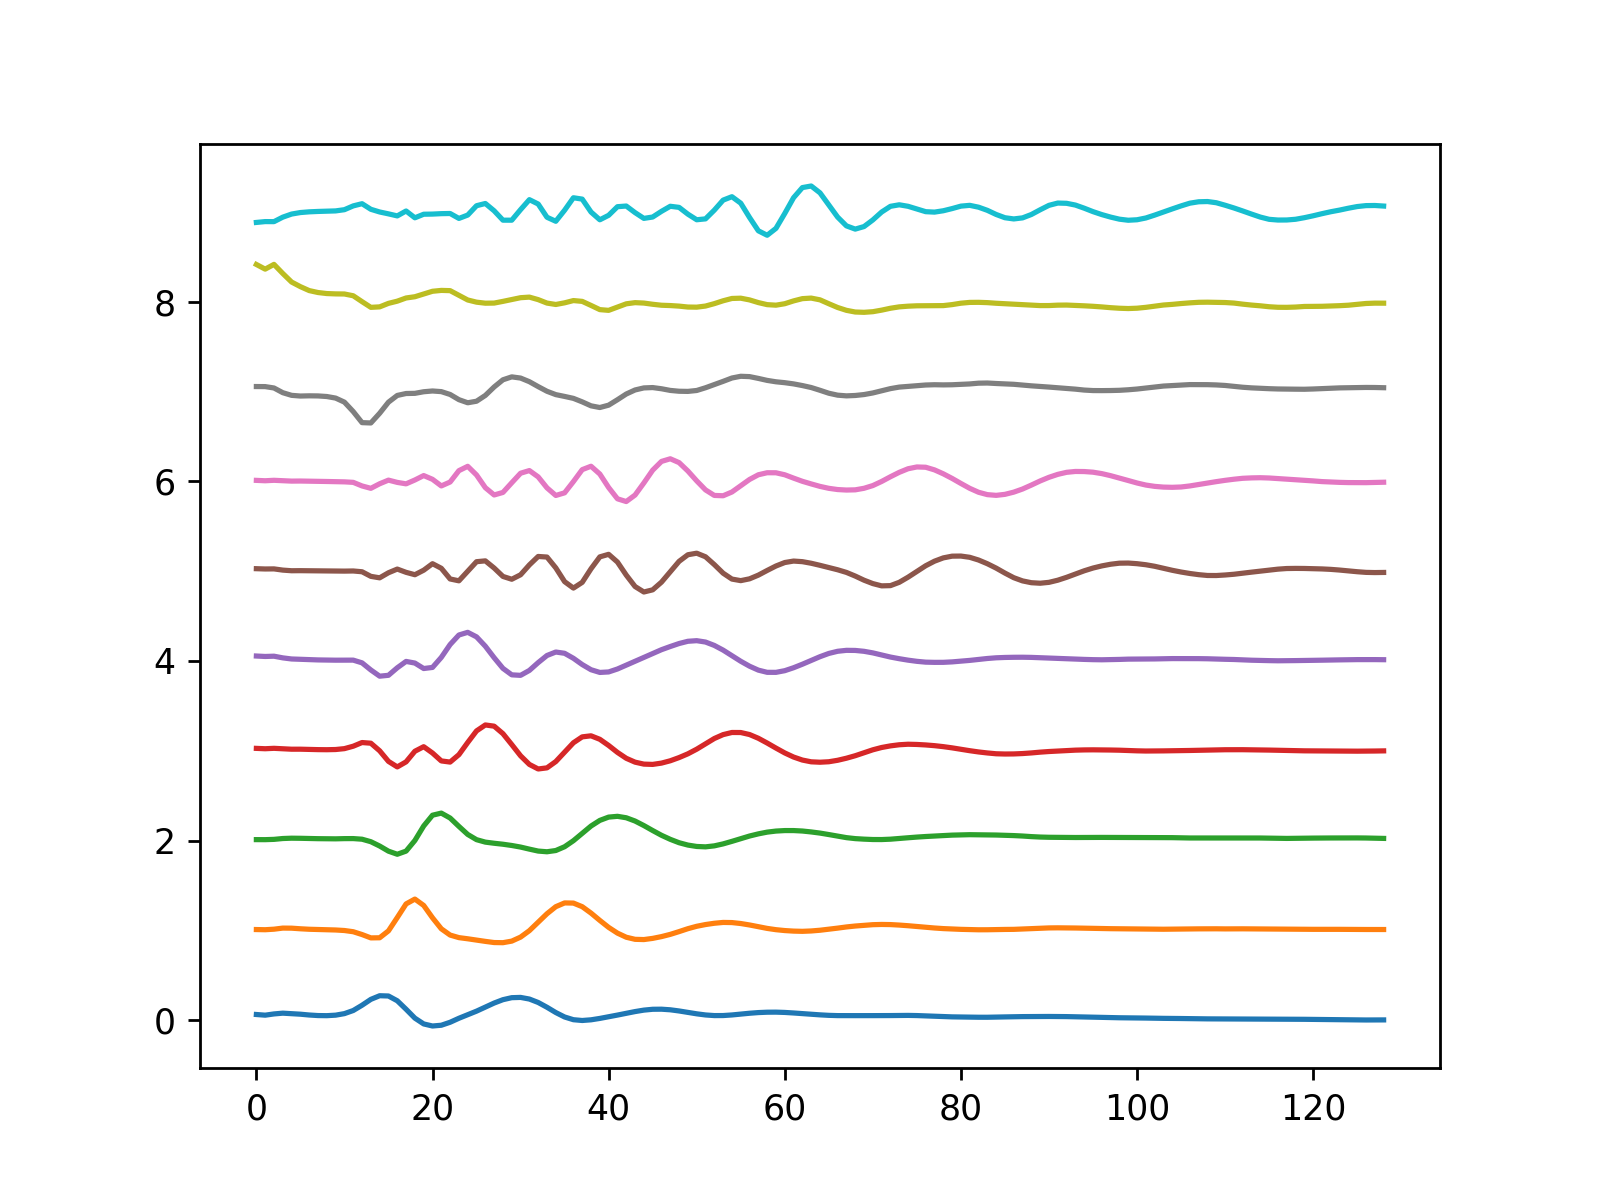

In [41]:
# Understanding the components
plt.figure()
plt.plot(pca.components_.T+np.array(range(10)))
plt.show()

PCA is a powerful tool for dimensionality reduction. It can be computed using efficient SVD solvers, and the components have meaningful ordering.

Some observations:
* a few dominant components may explain all the variance and overshadow some important less prominent components. 

* individual modes sometimes exaplain similar phenomena, i.e. the modes are not *separated* enough

* the sign of the modes is not informative (we can flip the sign and if we flip the sign of the eigenvalue)

There are a few other methods which try to address these issues:
* Independent Component Analysis
* Nonnegative Matrix factorization. 
* ...

Syntax in `scikit-learn` is almost the same for all decomposition methods!

---
### ICA decomposition 

In [16]:
ica = decomposition.FastICA(n_components=10)
ica.fit(XX)
XX_transformed = ica.transform(XX)


We notice ICA takes much longer to compute. While PCA relies on efficient SVD decomposition algorithms, ICA is solved by iteratively solving an optimization problem.

<IPython.core.display.Javascript object>


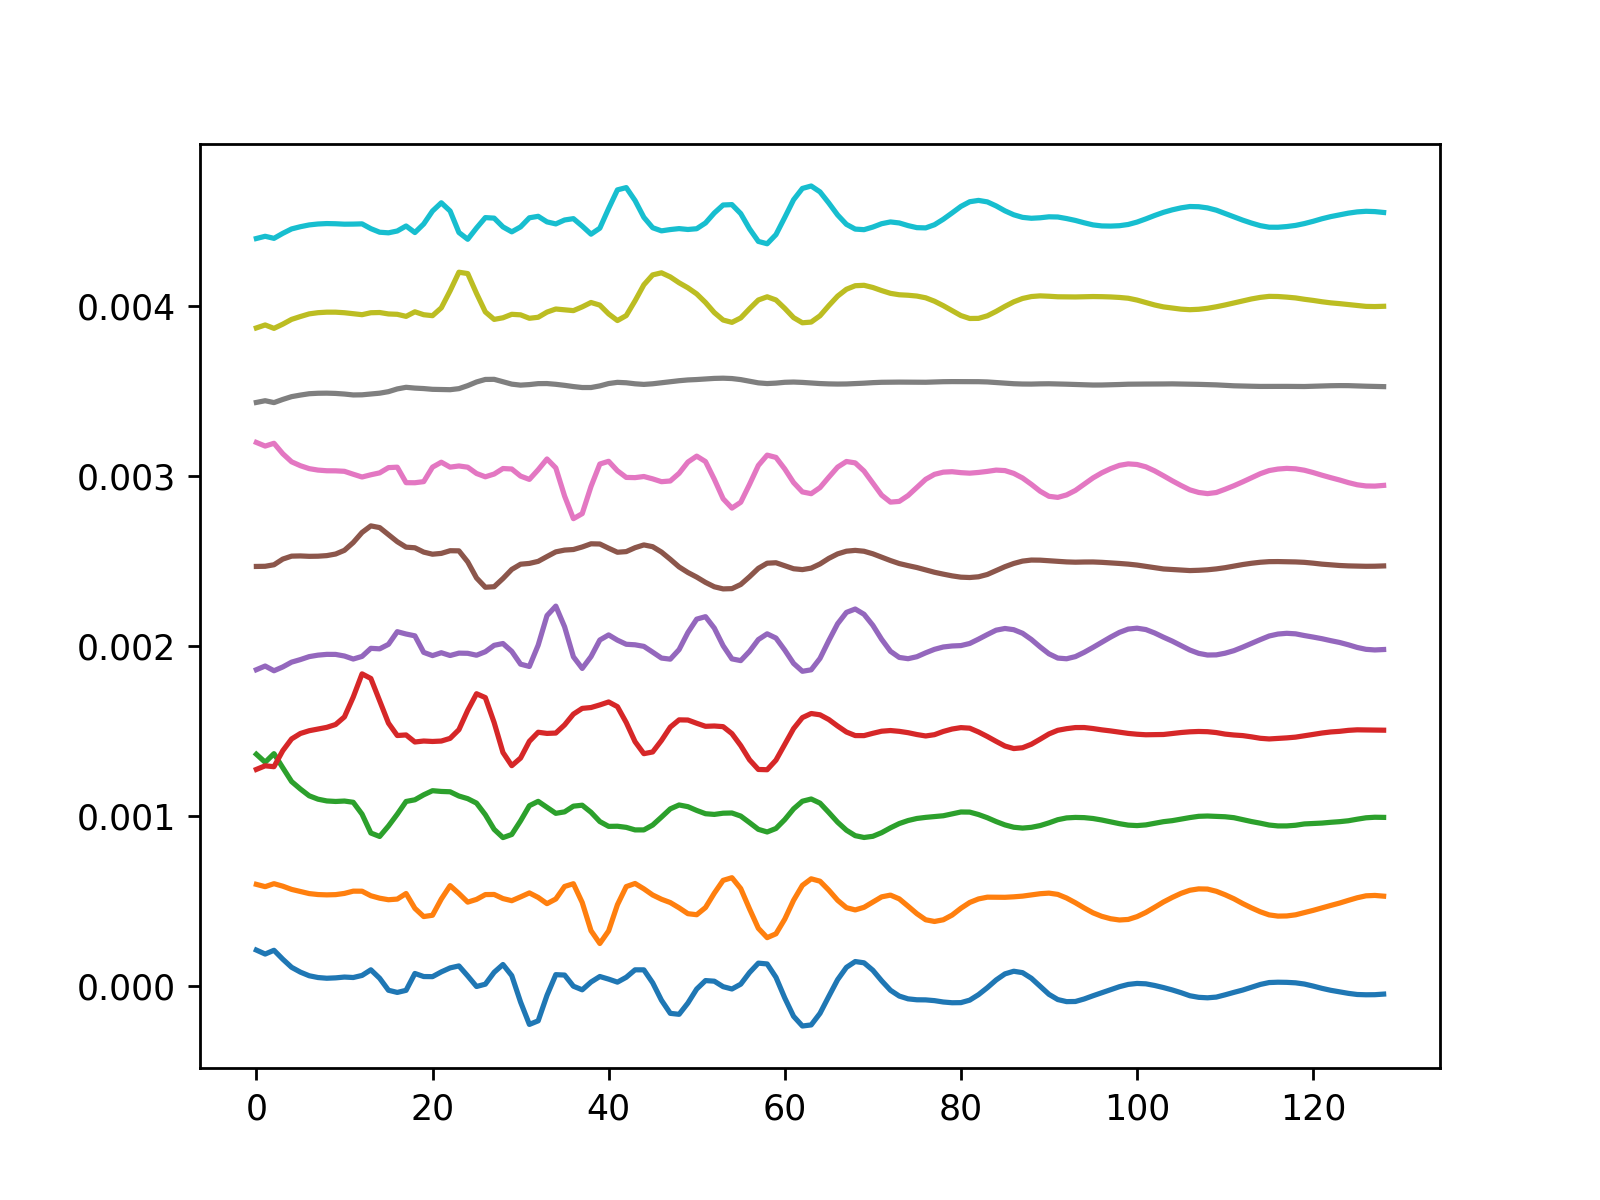

In [17]:
# Understanding the components
plt.figure()
plt.plot(ica.components_.T+0.0005*np.array(range(10)))
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,4))
plt.clf()
ax = Axes3D(fig)
sc = ax.scatter(XX_transformed[:, 0], XX_transformed[:, 1], XX_transformed[:, 2], c=y, cmap=plt.cm.spectral,
           edgecolor='k')

colors = [sc.cmap(sc.norm(i)) for i in np.unique(y)]
custom_lines = [plt.Line2D([],[], ls="", marker='o',mec='k', mfc=c, mew=.1, ms=5) for c in colors]
ax.legend(custom_lines, [lt for lt in target_names],loc='upper right', fontsize=7)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.show()

---
### Nonnegative Matrix Decomposition

In [18]:
nmf = decomposition.NMF(n_components=10)
nmf.fit(-XX)
XX_transformed = nmf.transform(-XX)

In [19]:
XX.max()

-49.886395

<IPython.core.display.Javascript object>


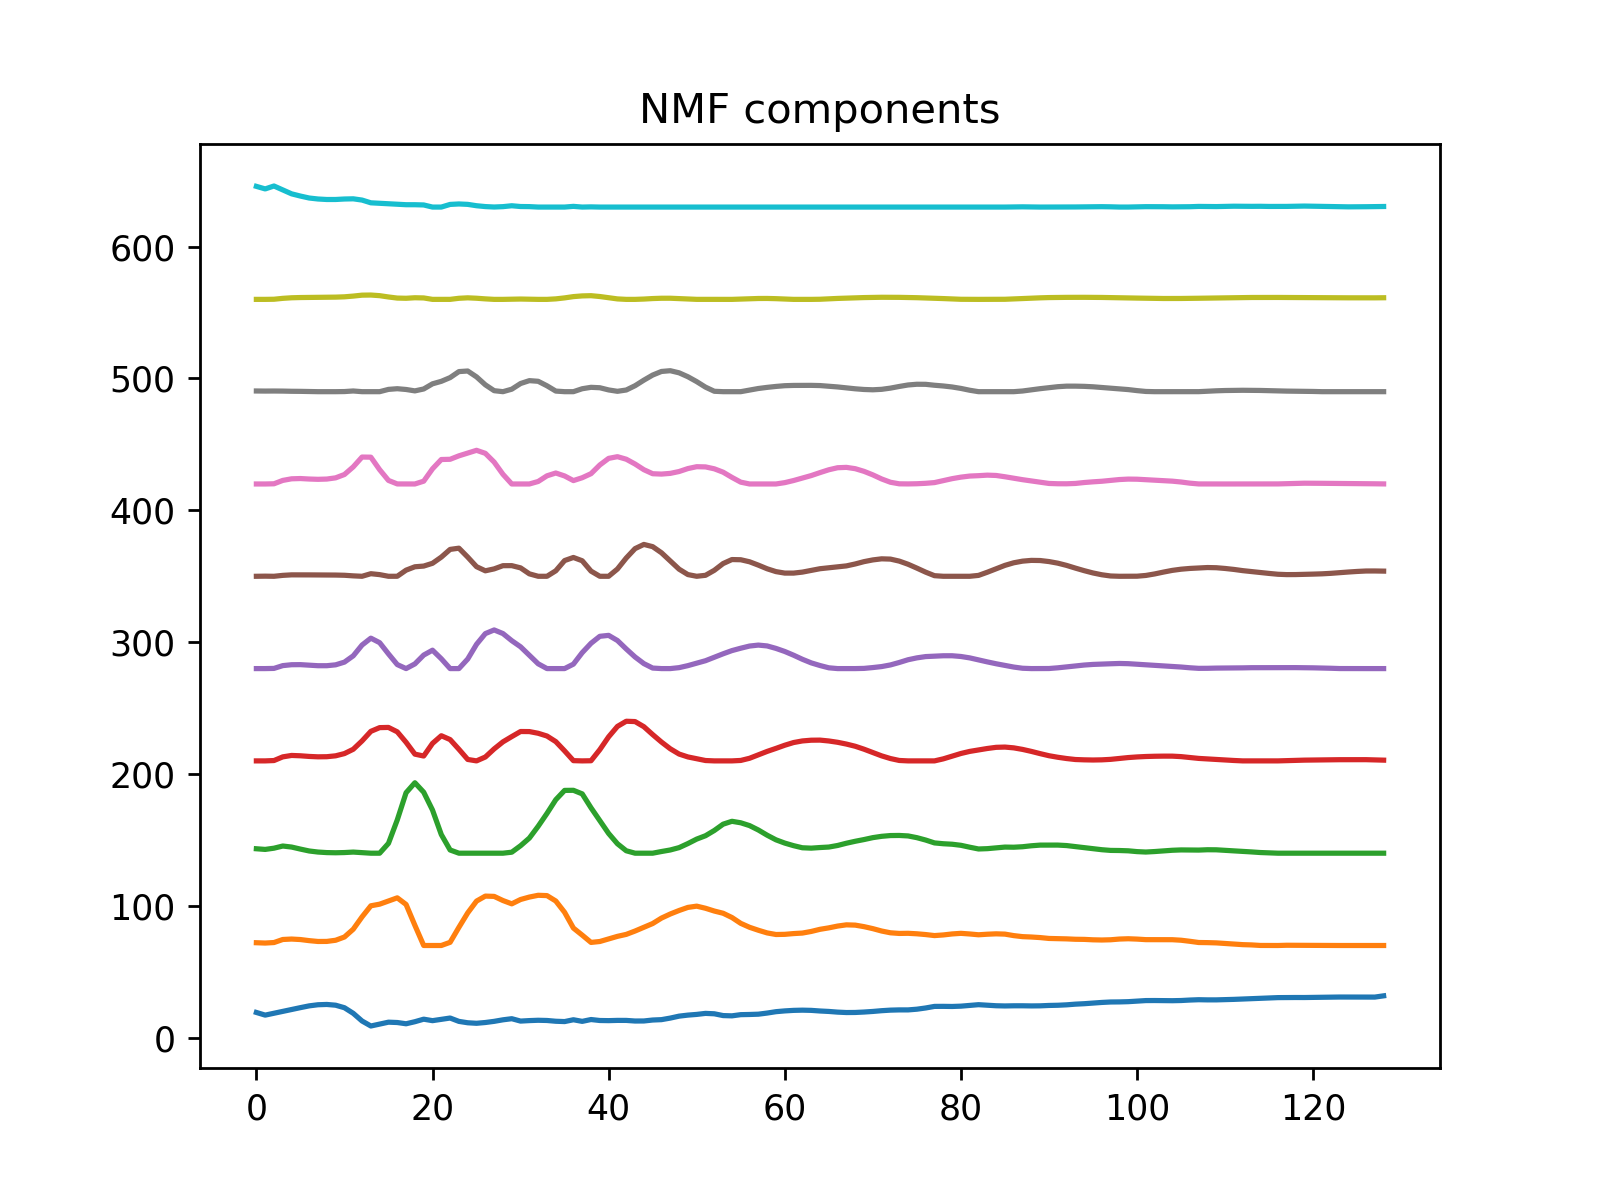

In [20]:
plt.figure()
plt.plot(nmf.components_.T+70*np.array(range(10)))
plt.title("NMF components")
plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 4))
plt.clf()
ax = Axes3D(fig)
sc = ax.scatter(XX_transformed[:, 0], XX_transformed[:, 1], XX_transformed[:, 2], c=y, cmap=plt.cm.spectral,
           edgecolor='k')

colors = [sc.cmap(sc.norm(i)) for i in np.unique(y)]
custom_lines = [plt.Line2D([],[], ls="", marker='o',mec='k', mfc=c, mew=.1, ms=5) for c in colors]
ax.legend(custom_lines, [lt for lt in target_names],loc='upper right', fontsize=7)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.draw()

One component corresponds to a drift???

***Exercise:***
    
* try out only 3 components
* do they coincide with the first three components of NMF with 10 components?

pros:
    
* components effect is additive: no cancelation

cons:
* nonconvex, different algorithms may give different results, [nimfa](http://nimfa.biolab.si/) package
* unordered
* non-nested (need to rerun the decomposition)

---
### Clustering

In [43]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(XX_transformed)
kmeans.labels_

array([1, 0, 0, ..., 0, 2, 2], dtype=int32)

Since we have the true labels, we can see whether there is any overlap between the and the cluster labels. For that we need to consider all permutations of the cluster names. Luckily, there is a function which does that for us [`v_measure_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html).

In [44]:
from sklearn.metrics import v_measure_score
v_measure_score(y, kmeans.labels_)

0.3109097737537454

This is pretty low, we can try some other methods.

Clustering performance optimization: [scikit-learn link](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

### Nonlinear Dimensionality Reduction

In [27]:
from sklearn.manifold import TSNE

In [28]:
%%time
from sklearn.manifold import TSNE
XX_transformed = TSNE(n_components=3).fit_transform(XX)
XX_transformed.shape

CPU times: user 3min 55s, sys: 11.7 s, total: 4min 7s
Wall time: 4min 7s


In [29]:
fig = plt.figure(1, figsize=(5, 5))
plt.clf()
ax = Axes3D(fig)
sc = ax.scatter(XX_transformed[:, 0], XX_transformed[:, 1], XX_transformed[:, 2], c=y, cmap=plt.cm.viridis,
           edgecolor='k')

colors = [sc.cmap(sc.norm(i)) for i in np.unique(y)]
custom_lines = [plt.Line2D([],[], ls="", marker='o',mec='k', mfc=c, mew=.1, ms=5) for c in colors]
ax.legend(custom_lines, [lt for lt in target_names],loc='upper right', fontsize=7)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.draw()

Nonlinear dimensionality reduction methods allow for more flexibility in finding the best separation for the points.

Other methods: [comparison](http://scikit-learn.org/stable/modules/clustering.html)

***Advice for working with time series:***
* when signals are of different length
    * if we can assume they exhibit some sort of stationary behavior, we can fit ARMA models and cluster the coefficients of the linear systems
    * if we can calculate some meaningful distance between the contours by warping them one on another, we can use these distances to embed the signals in a low-dimensional space
    * 
* when signals are time-shifted
    * if the shifts are constant we can align them by maximizing cross-correlation
    * or we can use a distance metric that is invariant by translation
* we can incorporate temporal constraints within the 

***Exercise:*** use [hierarchical clustering](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) and see if you can recover the hierarchy of the species. 